<a href="https://colab.research.google.com/github/mfilipak/FILIPAK-DATA-SCIENCE/blob/main/DIA5e6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AULA 05 - GERADORES E AUGMENTATION


### PARTE 1 - Carregar um modelo pré-treinado para classificação IMAGENET

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from glob import glob
import random
import cv2

# Carregar o modelo MobileNetV2 pré-treinado na ImageNet
model = MobileNetV2(weights='imagenet')



14536120/14536120 [==============================] - 2s 0us/step


### PARTE 2 - Carregar um dataset com imagens de fogo e não fogo (https://github.com/cair/Fire-Detection-Image-Dataset)

In [2]:
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Fire%20images.rar?raw=true' -O fire_images.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%201.rar?raw=true' -O non_fire_images_01.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%202.rar?raw=true' -O non_fire_images_02.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%203.rar?raw=true' -O non_fire_images_03.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%204.rar?raw=true' -O non_fire_images_04.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%205.rar?raw=true' -O non_fire_images_05.rar
clear_output()


In [3]:
!unrar x fire_images.rar /content/fire/ -y
!unrar x non_fire_images_01.rar /content/nonfire/ -y
!unrar x non_fire_images_02.rar /content/nonfire/ -y
!unrar x non_fire_images_03.rar /content/nonfire/ -y
!unrar x non_fire_images_04.rar /content/nonfire/ -y
!unrar x non_fire_images_05.rar /content/nonfire/ -y
clear_output()


In [4]:
fire_list = sorted(glob("./fire/**/*.*", recursive=True))
nonfire_list = sorted(glob("./nonfire/**/*.*", recursive=True))
print(len(fire_list), len(nonfire_list))

110 541


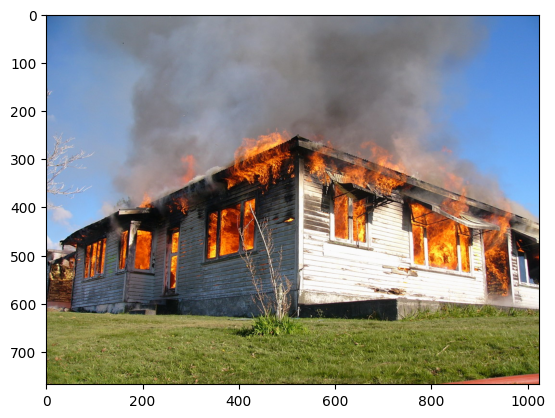

In [5]:
for f in fire_list[15:16]:
  img = cv2.imread(f)[...,::-1]
  plt.imshow(img)
  plt.show()

### PARTE 3 - Prediçoes do modelo pré-treinado

35363/35363 [==============================] - 0s 1us/step
[('n09472597', 'volcano', 0.31863263), ('n09288635', 'geyser', 0.13066529), ('n03388043', 'fountain', 0.05716417)]


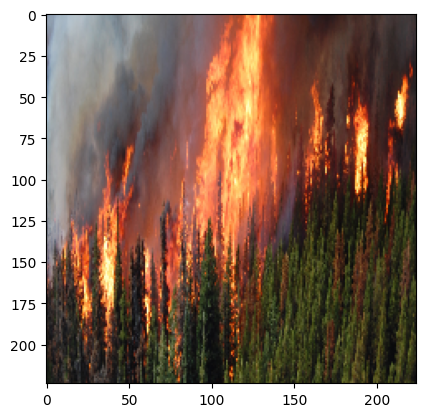

[('n03347037', 'fire_screen', 0.24925636), ('n09472597', 'volcano', 0.06768586), ('n02939185', 'caldron', 0.037805717)]


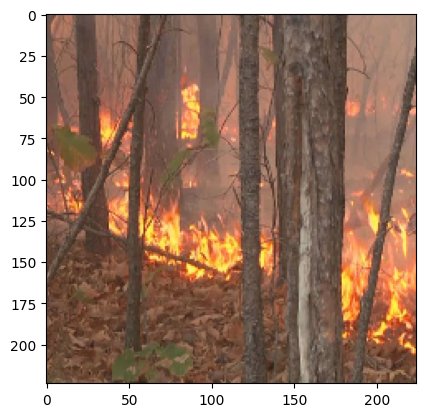

[('n09472597', 'volcano', 0.17176545), ('n03891251', 'park_bench', 0.09234787), ('n03837869', 'obelisk', 0.08018162)]


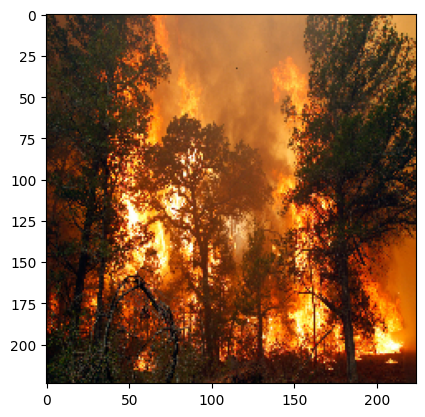

[('n09193705', 'alp', 0.2965199), ('n09468604', 'valley', 0.22238314), ('n09472597', 'volcano', 0.07565037)]


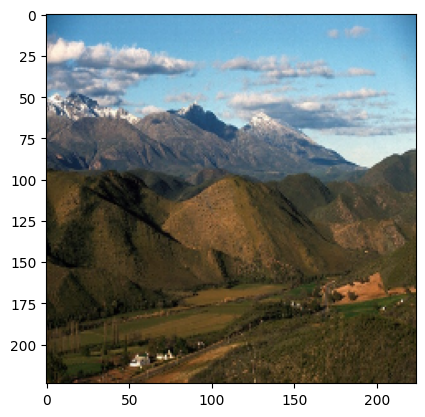

[('n03776460', 'mobile_home', 0.8077979), ('n02859443', 'boathouse', 0.0918006), ('n09332890', 'lakeside', 0.0073959148)]


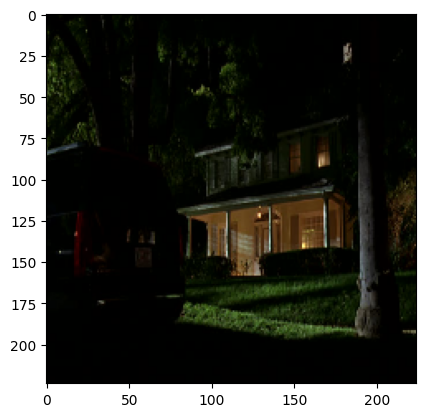

[('n03630383', 'lab_coat', 0.30724788), ('n03179701', 'desk', 0.13154797), ('n04004767', 'printer', 0.059174854)]


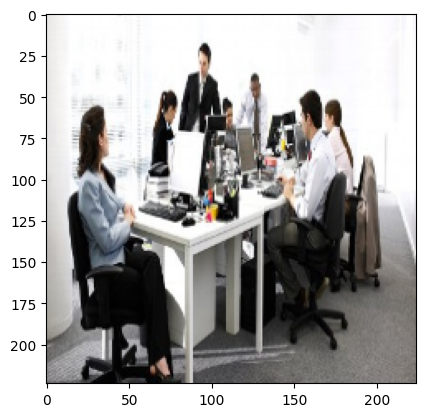

In [6]:
random.seed(41)
for f in random.sample(fire_list,3)+random.sample(nonfire_list,3):
  img = cv2.resize(cv2.imread(f)[...,::-1],(224,224))
  x = (2*(img[None,...]/255)-1).astype("float32") #Normalização min=-1,max=1
  y = model.predict(x, verbose=False)


  print(decode_predictions(y,top=3)[0])
  plt.imshow(img)
  plt.show()

In [7]:
#preds = model.predict(preprocess_input(img)[None,...], verbose=False)
#print('Predicted:', decode_predictions(preds, top=3)[0])

### PARTE 4 - Extrai do modelo MOBILENET o submodelo do "vetor latente"

In [8]:
model.layers[-5:], model.layers[-2]

([<keras.src.layers.convolutional.conv2d.Conv2D at 0x7c8ab0f0f760>,
 <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D at 0x7c8ab0f55cf0>)

In [9]:
submodel = Model(inputs=model.input, outputs=model.layers[-2].output)

In [10]:
submodel.layers[-5:], submodel.output_shape

([<keras.src.layers.normalization.batch_normalization.BatchNormalization at 0x7c8ab0f381f0>,
 (None, 1280))

# AUGMENTATIONS

In [11]:
import albumentations as A

In [12]:
img = cv2.imread(nonfire_list[0])[...,::-1]

In [13]:
myfn = A.RandomBrightnessContrast(0.3, p=1)
myfn(image=img)["image"].shape

(1087, 1500, 3)

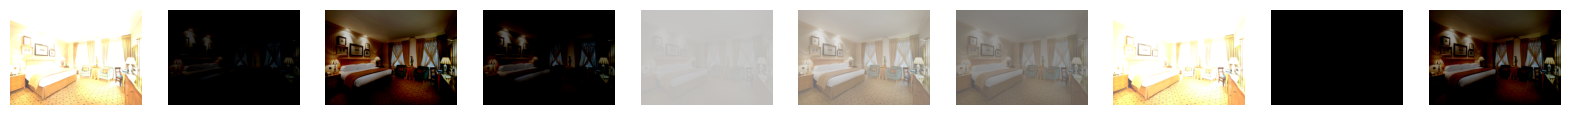

In [14]:
plt.figure(figsize=(20,5))
for i in range(10):
  plt.subplot(1,10,i+1), plt.axis("off")
  plt.imshow(A.RandomBrightnessContrast(1,1,p=1)(image=img)["image"])

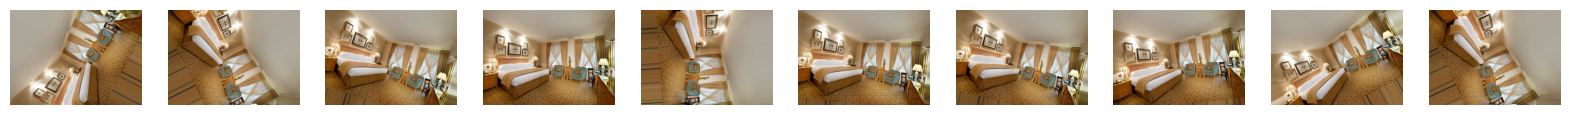

In [15]:
plt.figure(figsize=(20,5))
for i in range(10):
  plt.subplot(1,10,i+1), plt.axis("off")
  plt.imshow(A.Rotate(p=1, border_mode=cv2.BORDER_REPLICATE)(image=img)["image"])
plt.show()

In [16]:
transform = A.Compose(
    [ A.RandomBrightnessContrast(p=1),
    A.Rotate(p=1),
    A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1),
    A.Resize(224,224)
    ]
)

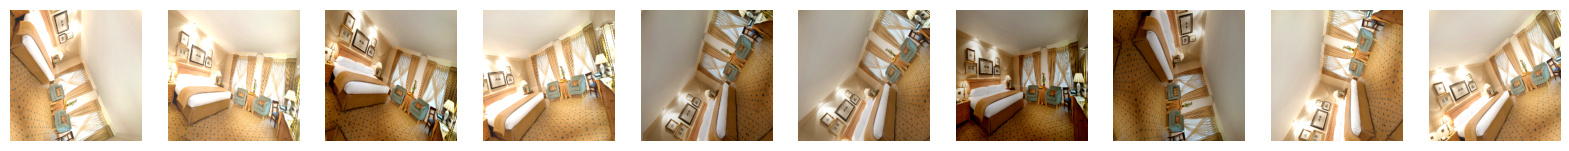

In [17]:
plt.figure(figsize=(20,5))
for i in range(10):
  plt.subplot(1,10,i+1), plt.axis("off")
  plt.imshow(transform(image=img)["image"])
plt.show()

### PARTE 5 - GERADOR

In [18]:
all_list = [[_,1] for _ in fire_list]+[[_,0] for _ in nonfire_list]


In [19]:
X = np.array(all_list)[...,0]
Y = np.array(all_list)[...,1]
X[:3],Y[:3]

(array(['./fire/Fire images/1.jpg', './fire/Fire images/10-9-15-2-400.jpg',
        './fire/Fire images/11_10_19-mjs_ft_hotel-fire_19183862.jpg'],
       dtype='<U238'),
 array(['1', '1', '1'], dtype='<U238'))

In [20]:
len(X),len(Y)

(651, 651)

In [21]:
size_test=64
idx = list(range(len(X)))
random.shuffle(idx)
X_test = X[idx[:size_test]]
Y_test = Y[idx[:size_test]]
X_train = X[idx[size_test:]]
Y_train = Y[idx[size_test:]]

In [22]:
def mygenerator(X,Y,batch_size=64):
  aux = list(zip(X,Y))

  while(True):
    if len(aux) >= batch_size:
      tmp = aux[:batch_size]
      x = np.array([transform(image=cv2.imread(_[0])[...,::-1])["image"] for _ in tmp])
      y = [_[1] for _ in tmp]
      yield submodel.predict(2*(x/255)-1, verbose=False),np.array(y).astype("float32")
      aux = aux[batch_size:]
    else:
      aux += list(zip(X,Y))
      random.shuffle(aux)


In [23]:
g = mygenerator(X_train,Y_train,64)

In [24]:
xx,yy = next(g)

In [25]:
train_gen = mygenerator(X_train,Y_train)
test_gen = mygenerator(X_test,Y_test)

In [26]:
from tensorflow.keras import models, layers

# Definir o modelo
classif = models.Sequential(name='classif')

# Adicionar a camada de entrada com 1280 neurônios
classif.add(layers.Dense(256, activation='relu', input_shape=(1280,)))

# Adicionar mais algumas camadas densas
classif.add(layers.Dense(128, activation='relu'))
classif.add(layers.Dense(64, activation='relu'))

# Adicionar a camada de saída com 1 neurônio para classificação binária
classif.add(layers.Dense(1, activation='sigmoid'))

# Compilar o modelo
classif.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Resumo do modelo
classif.summary()


Model: "classif"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 369153 (1.41 MB)
Trainable params: 369153 (1.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
classif.input_shape, xx.shape

((None, 1280), (64, 1280))

In [28]:
len(X_train)/64

9.171875

In [29]:
!wget https://github.com/mfilipak/FILIPAK-DATA-SCIENCE/raw/main/MODELS/TRANSFER_LEARNING_MOBILENET_FIRE.H5
try:
  classif = tf.keras.models.load_model("TRANSFER_LEARNING_MOBILENET_FIRE.H5")
except:
  classif.fit(train_gen, steps_per_epoch=9, validation_data=test_gen, validation_steps=1, epochs=10)
  classif.save("./TRANSFER_LEARNING_MOBILENET_FIRE.H5", save_format="h5")


--2024-03-21 12:48:19--  https://github.com/mfilipak/FILIPAK-DATA-SCIENCE/raw/main/MODELS/TRANSFER_LEARNING_MOBILENET_FIRE.H5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mfilipak/FILIPAK-DATA-SCIENCE/main/MODELS/TRANSFER_LEARNING_MOBILENET_FIRE.H5 [following]
--2024-03-21 12:48:20--  https://raw.githubusercontent.com/mfilipak/FILIPAK-DATA-SCIENCE/main/MODELS/TRANSFER_LEARNING_MOBILENET_FIRE.H5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4471304 (4.3M) [application/octet-stream]
Saving to: ‘TRANSFER_LEARNING_MOBILENET_FIRE.H5’

TRANSFER_LEARNING_M 100%[===================>]   4.26M  -

In [30]:
classif.summary()

Model: "classif"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 369153 (1.41 MB)
Trainable params: 369153 (1.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# DATA VISUALIZATIONS

In [33]:
#Pega um batch de imagens do gerador e separa em 2 listas (com e sem fogo)
x,y = next(g)

x_fire = x[np.where(y==1)]
x_nonfire = x[np.where(y==0)]

x.shape, x_nonfire.shape, x_fire.shape

((64, 1280), (57, 1280), (7, 1280))

In [ ]:
#%matplotlib notebook
#%matplotlib inline

A ideia por trás de PCA (Principal Component Analisys)

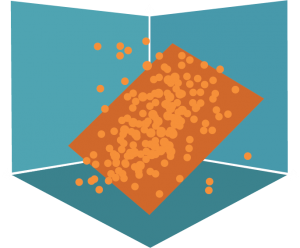

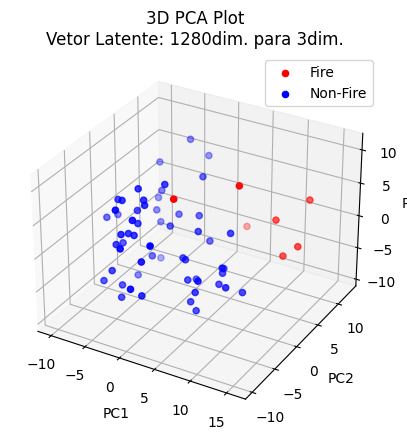

In [35]:
#Usando PCA (Principal Component Analisys)
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming x_fire and x_nonfire are your datasets
# Combine the two datasets
X = np.vstack((x_fire, x_nonfire))

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Split the reduced data back into fire and nonfire categories
x_fire_pca = X_pca[:len(x_fire)]
x_nonfire_pca = X_pca[len(x_fire):]

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for fire data in red
ax.scatter(x_fire_pca[:, 0], x_fire_pca[:, 1], x_fire_pca[:, 2], color='red', label='Fire')

# Scatter plot for nonfire data in blue
ax.scatter(x_nonfire_pca[:, 0], x_nonfire_pca[:, 1], x_nonfire_pca[:, 2], color='blue', label='Non-Fire')

ax.set_title("3D PCA Plot\nVetor Latente: 1280dim. para 3dim.")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()

plt.show()


In [39]:
#Usando plotly junto com pandas
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Assuming x_fire and x_nonfire are your datasets
# Combine the two datasets and create a label array
X = np.vstack((x_fire, x_nonfire))
labels = ['Fire'] * len(x_fire) + ['Non-Fire'] * len(x_nonfire)

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a DataFrame for Plotly
df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df['Type'] = labels

display(df)

# Plot using Plotly Express
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Type', title="3D PCA Plot")
fig.show()

,PC1,PC2,PC3,Type
0,14.144719,2.084467,0.320158,Fire
1,9.673249,-0.637004,10.949619,Fire
2,3.876252,-5.546980,10.179093,Fire
3,12.220115,3.538553,4.229965,Fire
4,6.566654,6.166771,-0.010826,Fire
...,...,...,...,...
59,-3.625096,-1.965528,7.429224,Non-Fire
60,-1.473608,0.438717,7.303089,Non-Fire
61,-2.636757,5.110467,-0.274026,Non-Fire
62,-4.968405,-5.711591,-3.068254,Non-Fire


In [40]:
submodel_l1 = Model(inputs=classif.input, outputs=classif.layers[0].output)

In [ ]:
submodel_l1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 1280)]            0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
Total params: 327936 (1.25 MB)
Trainable params: 327936 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
p1_fire = submodel_l1.predict(x_fire, verbose=False)
p1_nonfire = submodel_l1.predict(x_nonfire, verbose=False)

In [ ]:
X = np.vstack((p1_fire, p1_nonfire))
labels = ['Fire'] * len(p1_fire) + ['Non-Fire'] * len(p1_nonfire)

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a DataFrame for Plotly
df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df['Type'] = labels

# Plot using Plotly Express
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Type', title="3D PCA Plot")
fig.show()

In [ ]:
submodel_l2 = Model(inputs=classif.input, outputs=classif.layers[1].output)
p2_fire = submodel_l2.predict(x_fire, verbose=False)
p2_nonfire = submodel_l2.predict(x_nonfire, verbose=False)

X = np.vstack((p2_fire, p2_nonfire))
labels = ['Fire'] * len(p2_fire) + ['Non-Fire'] * len(p2_nonfire)

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a DataFrame for Plotly
df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df['Type'] = labels

# Plot using Plotly Express
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Type', title="3D PCA Plot")
fig.show()

In [ ]:
submodel_l3 = Model(inputs=classif.input, outputs=classif.layers[2].output)
p3_fire = submodel_l3.predict(x_fire, verbose=False)
p3_nonfire = submodel_l3.predict(x_nonfire, verbose=False)

X = np.vstack((p3_fire, p3_nonfire))
labels = ['Fire'] * len(p3_fire) + ['Non-Fire'] * len(p3_nonfire)

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a DataFrame for Plotly
df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df['Type'] = labels

# Plot using Plotly Express
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Type', title="3D PCA Plot")
fig.show()

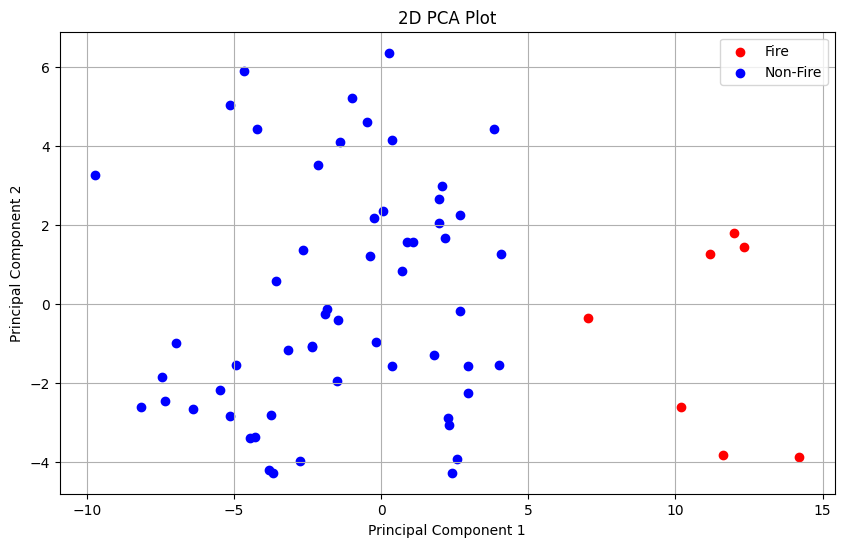

In [ ]:
# Assuming x_fire and x_nonfire are your datasets
# Combine the two datasets
X = np.vstack((p3_fire, p3_nonfire))


# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Split the reduced data back into fire and nonfire categories
x_fire_pca = X_pca[:len(x_fire)]
x_nonfire_pca = X_pca[len(x_fire):]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_fire_pca[:, 0], x_fire_pca[:, 1], color='red', label='Fire')
plt.scatter(x_nonfire_pca[:, 0], x_nonfire_pca[:, 1], color='blue', label='Non-Fire')
plt.title('2D PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

# Assuming x_fire and x_nonfire have shapes (7, 1280) and (57, 1280) respectively
# Combine the datasets
X = np.vstack((p3_fire, p3_nonfire))
labels = ['Fire'] * len(x_fire) + ['Non-Fire'] * len(x_nonfire)

# Perform PCA to reduce dimensions to 4
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

# Create a DataFrame for Plotly
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'])
df_pca['Type'] = labels

# The size for the markers can be adjusted by scaling the fourth principal component
# Adjust the scaling factor as necessary for your data
df_pca['Size'] = df_pca['PC4'].abs() * 50  # Example scaling, adjust as needed

# Plot using Plotly Express
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='Type', size='Size', title="4D PCA Plot")
fig.show()